In [19]:
#Importing essential libraries
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

#Initialising device
device = qml.device('default.qubit', wires = 4)

@qml.qnode(device, diff_method = "backprop")
def circuit(params):
  qml.StronglyEntanglingLayers(params, wires = [0, 1, 2, 3])
  return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

#initialize circuit parameters
param_shape = qml.StronglyEntanglingLayers.shape(n_wires = 4, n_layers = 15)
params = np.random.normal(scale = 0.1, size = param_shape, requires_grad = True)
print(circuit(params))

0.8655392960005129


In [20]:
#Calculating time needed to perform a forward pass
import timeit

reps = 3
num = 10

times = timeit.repeat("circuit(params)", globals = globals(), number = num, repeat = reps)
forward_time = min(times)/num
print(f"Forward pass (best of {reps}) : {forward_time} sec per loop")

Forward pass (best of 3) : 0.06910674230000495 sec per loop


In [21]:
#Calculating time needed to perform backpropagation
times = timeit.repeat("qml.grad(circuit)(params)", globals = globals(), number = num, repeat = reps)
backward_time = min(times)/num
print(f"Backward pass (best of {reps}): {backward_time} per loop")

Backward pass (best of 3): 0.13262874480001302 per loop


In [30]:
dev = qml.device("default.qubit", wires=4)

def circuit(params):
    qml.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

In [29]:
reps = 2
num = 3

forward_shift = []
gradient_shift = []
forward_backprop = []
gradient_backprop = []

for depth in range(0, 21):
    param_shape = qml.StronglyEntanglingLayers.shape(n_wires=4, n_layers=depth)
    params = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)
    num_params = params.size

    # forward pass timing
    # ===================

    qnode_shift = qml.QNode(circuit, dev, diff_method="parameter-shift")
    qnode_backprop = qml.QNode(circuit, dev, diff_method="backprop")

    # parameter-shift
    t = timeit.repeat("qnode_shift(params)", globals=globals(), number=num, repeat=reps)
    forward_shift.append([num_params, min(t) / num])

    # backprop
    t = timeit.repeat("qnode_backprop(params)", globals=globals(), number=num, repeat=reps)
    forward_backprop.append([num_params, min(t) / num])

    if num_params == 0:
        continue

    # Gradient timing
    # ===============

    qnode_shift = qml.QNode(circuit, dev, diff_method="parameter-shift")
    qnode_backprop = qml.QNode(circuit, dev, diff_method="backprop")

    # parameter-shift
    t = timeit.repeat("qml.grad(qnode_shift)(params)", globals=globals(), number=num, repeat=reps)
    gradient_shift.append([num_params, min(t) / num])

    # backprop
    t = timeit.repeat("qml.grad(qnode_backprop)(params)", globals=globals(), number=num, repeat=reps)
    gradient_backprop.append([num_params, min(t) / num])

gradient_shift = np.array(gradient_shift).T
gradient_backprop = np.array(gradient_backprop).T
forward_shift = np.array(forward_shift).T
forward_backprop = np.array(forward_backprop).T

[]

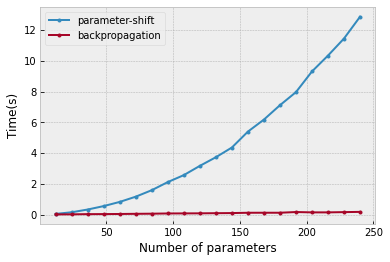

In [31]:
#Using matplotlib to plot the results
plt.style.use("bmh")

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

ax.plot(*gradient_shift, '.-', label = "parameter-shift")
ax.plot(*gradient_backprop, '.-', label = "backpropagation")
ax.set_xlabel("Number of parameters")
ax.set_ylabel("Time(s)")
ax.legend()

plt.plot()